Predicting finally

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 1</span>
    <h1 style="font-size: 30px;">Dataset Preperation </h1>
</div>

In [1]:
import pyarrow.feather as feather
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.inspection import PartialDependenceDisplay, partial_dependence

In [2]:
#Load the feather file into a car_df
car_df = feather.read_feather('processed_data.feather')

In [3]:
car_df.columns

Index(['year', 'brand', 'model', 'trim', 'body', 'transmission', 'condition',
       'odometer', 'color', 'interior', 'mmr', 'sellingprice', 'brand_model',
       'car_age', 'mileage_per_year', 'market_price_deviation', 'brand_label',
       'trim_label', 'body_label', 'color_label', 'interior_label',
       'transmission_label'],
      dtype='object')

In [4]:
car_df.head()

,year,brand,model,trim,body,transmission,condition,odometer,color,interior,...,brand_model,car_age,mileage_per_year,market_price_deviation,brand_label,trim_label,body_label,color_label,interior_label,transmission_label
2,2014,Bmw,3 Series,Others,Sedan,Automatic,1.145277,-1.364964,Silver,Black,...,Bmw_3 Series,-1.021999,-2.023111,-1.773132,8,0,1,1,1,0
3,2015,Others,Others,Others,Sedan,Automatic,0.719401,-1.086219,White,Black,...,Others_Others,-1.311799,-0.107857,0.287817,0,0,1,3,1,0
4,2014,Bmw,Others,Others,Sedan,Automatic,0.932339,-1.336769,Silver,Black,...,Bmw_Others,-1.311799,-0.107857,1.006753,8,0,1,1,1,0
6,2014,Bmw,Others,Base,Sedan,Automatic,-0.025882,-1.071992,Black,Black,...,Bmw_Others,-1.311799,-0.107857,0.000243,8,1,1,2,1,0
7,2014,Chevrolet,Others,Others,Sedan,Automatic,-1.516450,-0.777685,Black,Black,...,Chevrolet_Others,-1.311799,-0.107857,-1.964848,2,0,1,2,1,0


> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>Train, test, validation split</b></font></div>

In [5]:
X = car_df[['year', 'mmr', 'odometer','condition', 'car_age', 'mileage_per_year', 'market_price_deviation', 
            'brand_label', 'trim_label', 'body_label', 'color_label', 'interior_label',
            'transmission_label']].copy()
y = car_df[['sellingprice']].copy()

In [6]:
#Splitting the original dataset into train and test sets (80-20 split)
X_train_test, X_test, y_train_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Further splitting the training-test set into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X_train_test, y_train_test, test_size=0.2, random_state=77)

In [7]:
#Checking the sizes or shapes of each set
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

#Printing a few rows from each set to inspect the data
print("\nSample rows from Train set:")
print(X_train.head())
print(y_train.head())

print("\nSample rows from Validation set:")
print(X_val.head())
print(y_val.head())

print("\nSample rows from Test set:")
print(X_test.head())
print(y_test.head())

Train set shape: (357510, 13) (357510, 1)
Validation set shape: (89378, 13) (89378, 1)
Test set shape: (111722, 13) (111722, 1)

Sample rows from Train set:
        year       mmr  odometer  condition   car_age  mileage_per_year  \
417744  2013  1.678418 -1.080730   1.571154 -0.732200         -1.144580   
294478  2012  1.401142 -0.373266   0.825870 -0.442400          0.118112   
481987  2013 -0.457269 -0.237305  -0.558228 -0.732200          1.754535   
78199   2002 -1.411232 -0.268589  -2.581140  2.455598          0.157706   
20667   2006 -1.460745  2.516962   0.000215  1.006599          1.140414   

        market_price_deviation  brand_label  trim_label  body_label  \
417744               -0.718693            1           0           2   
294478                1.006753            1           6           2   
481987               -0.455083            7           9           1   
78199                -0.526976            3           2           2   
20667                -0.071650       

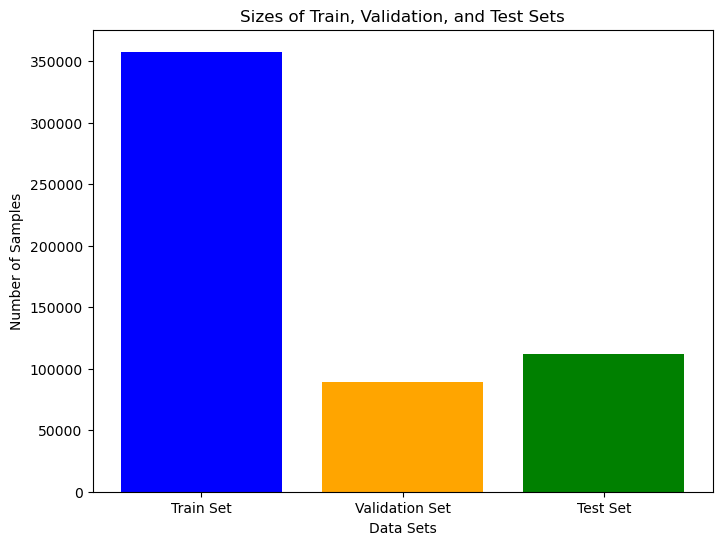

In [8]:
#Checking the sizes of each dataset
#Data for plotting
sets = ['Train Set', 'Validation Set', 'Test Set']  #Labels for different dataset types
sizes = [len(X_train), len(X_val), len(X_test)]  #Number of samples in each dataset

#Plotting the sizes of datasets
plt.figure(figsize=(8, 6)) 
plt.bar(sets, sizes, color=['blue', 'orange', 'green'])
plt.xlabel('Data Sets') 
plt.ylabel('Number of Samples')
plt.title('Sizes of Train, Validation, and Test Sets') 
plt.show()

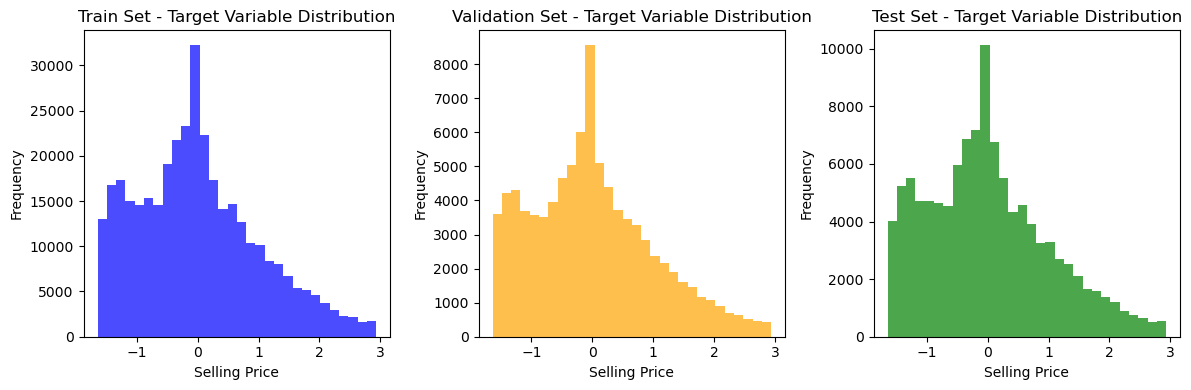

In [9]:
#Plotting histograms for the target variable in each dataset
plt.figure(figsize=(12, 4))

#Subplot for Train Set
plt.subplot(1, 3, 1)
plt.hist(y_train, bins=30, color='blue', alpha=0.7) 
plt.title('Train Set - Target Variable Distribution')
plt.xlabel('Selling Price')  
plt.ylabel('Frequency')

#Subplot for Validation Set
plt.subplot(1, 3, 2)
plt.hist(y_val, bins=30, color='orange', alpha=0.7) 
plt.title('Validation Set - Target Variable Distribution')  
plt.xlabel('Selling Price')  
plt.ylabel('Frequency')

#Subplot for Test Set
plt.subplot(1, 3, 3) 
plt.hist(y_test, bins=30, color='green', alpha=0.7)
plt.title('Test Set - Target Variable Distribution')
plt.xlabel('Selling Price') 
plt.ylabel('Frequency')

plt.tight_layout() 
plt.show()

#### From examining the graphs, it's clear that the distribution of the target variable across the train, validation, and test datasets is highly comparable. This suggests a well-executed splitting of the data into these subsets.

In [10]:
X_train.head()

,year,mmr,odometer,condition,car_age,mileage_per_year,market_price_deviation,brand_label,trim_label,body_label,color_label,interior_label,transmission_label
417744,2013,1.678418,-1.080730,1.571154,-0.732200,-1.144580,-0.718693,1,0,2,4,1,0
294478,2012,1.401142,-0.373266,0.825870,-0.442400,0.118112,1.006753,1,6,2,1,1,0
481987,2013,-0.457269,-0.237305,-0.558228,-0.732200,1.754535,-0.455083,7,9,1,3,4,0
78199,2002,-1.411232,-0.268589,-2.581140,2.455598,0.157706,-0.526976,3,2,2,0,2,0
20667,2006,-1.460745,2.516962,0.000215,1.006599,1.140414,-0.071650,7,3,1,0,0,0


In [11]:
X_test.head()

,year,mmr,odometer,condition,car_age,mileage_per_year,market_price_deviation,brand_label,trim_label,body_label,color_label,interior_label,transmission_label
243545,2010,-0.734546,0.425736,-0.877635,0.137200,0.281414,-1.221948,5,2,4,1,3,0
94742,2002,-1.520162,2.657616,-1.622919,2.455598,-0.077692,0.072137,0,4,2,0,2,0
429004,2012,-0.229507,-0.426105,0.080587,-0.442400,-0.002971,-0.191473,3,0,1,1,1,0
223237,2012,0.041168,-1.067644,1.145277,-0.442400,-1.473083,0.048172,3,0,1,0,2,0
46574,2006,-0.632217,-0.086084,-0.025882,1.006599,-1.096455,0.719179,0,0,1,2,4,1


In [41]:
X_val.head()

,year,mmr,odometer,condition,car_age,mileage_per_year,market_price_deviation,brand_label,trim_label,body_label,color_label,interior_label,transmission_label
327760,2009,-1.196673,1.315823,0.293525,0.426999,0.884339,-0.359225,1,10,1,4,3,0
503370,2007,-0.757652,0.759257,0.080587,1.006599,-0.370030,-0.958338,4,0,1,2,2,0
116018,2008,-0.727944,0.734312,-0.877635,0.716799,-0.130240,-0.119579,3,0,2,3,1,0
73529,2014,1.480364,-1.263849,0.719401,-1.021999,-1.327980,-0.431118,0,0,2,0,1,0
198543,2013,-0.011647,-0.141828,0.825870,-0.732200,2.082717,0.335747,3,10,2,1,2,0


<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 2</span>
    <h1 style="font-size: 30px;">Model Fitting </h1>
</div>

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>Random Forest</b></font></div>

In [42]:
#Initialise a Random Forest Regressor with specified hyperparameters
random_forest = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=420)

#Train the model using the training data
random_forest.fit(X_train, y_train)

#Make predictions on the validation set
rf_predictions = random_forest.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, rf_predictions) 
mae = mean_absolute_error(y_val, rf_predictions)

#Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

/Users/cansenturk/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE): 0.04
Mean Absolute Error (MAE): 0.05


#### The MSE value of 0.04 signifies the average squared difference between the predicted and actual values in the validation set. Lower MSE values typically indicate better performance, suggesting that, on average, the model's predictions closely align with the actual values in the validation set. Additionally, the Mean Absolute Error (MAE) of 0.05 provides another measure of prediction accuracy, representing the average absolute difference between the predicted and actual values. Both a low MSE and a low MAE, such as these values, suggest that the model is making accurate predictions and has an excellent fit for the validation data.

In [154]:
#Convert y_train to a 1-dimensional array using ravel
y_train_1d = np.ravel(y_train)

#Create a Random Forest Regressor model with specified parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=420)

#Perform 5-fold cross-validation using negative mean squared error as the scoring metric
cv_scores = cross_val_score(rf, X_train, y_train_1d, cv=5, scoring='neg_mean_squared_error')

#Convert the negative scores to positive since neg_mean_squared_error is used
cv_scores = -cv_scores

#Display the cross-validation scores for each fold
print("Cross-validation Scores:", cv_scores)

#Calculate the mean cross-validation score
print("Mean CV Score:", cv_scores.mean())

Cross-validation Scores: [0.03574111 0.03624268 0.03629695 0.0395317  0.03718918]
Mean CV Score: 0.03700032554229241


#### The average score from cross-validation is 0.037. These scores show how well the model performs when tested on different parts of the data. An average score of 0.037 suggests the model generally predicts the target quite accurately across different sections of the dataset used for validation. This means the model tends to make predictions with a fairly low error consistently across various parts of the data.

#### The accuracy could be better, so by hyperparameter tuning with a random grid we want to find better hyper parameters

In [155]:
#Defining a large and refined parameter grid
param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': randint(5, 20), 
}

#Randomised Search with 5-fold cross-validation
rf = RandomForestRegressor(random_state=420)
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=10, cv=5,
                                   scoring='neg_mean_squared_error', random_state=420, n_jobs=-1)
random_search.fit(X_train, y_train_1d)

#Get the best hyperparameters and best score
best_params_random = random_search.best_params_
best_score_random = -random_search.best_score_

print("Best Hyperparameters (Randomized Search):", best_params_random)
print("Best CV Score (Randomized Search):", best_score_random)

#Accessing the results of Randomized Search
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values(by='rank_test_score')  #Sorting by rank for better visibility
desired_columns = ['params', 'mean_test_score', 'rank_test_score']
print("\nParameters Tried in Randomized Search:")
print(results_df[desired_columns])

Best Hyperparameters (Randomized Search): {'max_depth': 19, 'n_estimators': 280}
Best CV Score (Randomized Search): 0.033523960117844934

Parameters Tried in Randomized Search:
                                   params  mean_test_score  rank_test_score
6  {'max_depth': 19, 'n_estimators': 280}        -0.033524                1
5  {'max_depth': 19, 'n_estimators': 201}        -0.033608                2
4  {'max_depth': 15, 'n_estimators': 378}        -0.033682                3
3  {'max_depth': 14, 'n_estimators': 204}        -0.033912                4
8  {'max_depth': 13, 'n_estimators': 182}        -0.034212                5
1  {'max_depth': 11, 'n_estimators': 113}        -0.035622                6
9  {'max_depth': 10, 'n_estimators': 232}        -0.036974                7
7   {'max_depth': 9, 'n_estimators': 341}        -0.039743                8
2   {'max_depth': 8, 'n_estimators': 480}        -0.042948                9
0   {'max_depth': 6, 'n_estimators': 122}        -0.057648     

#### The code searched various hyperparameter combinations for a Random Forest Regressor. After assessing multiple settings, it was found that using 280 estimators and a maximum tree depth of 19 resulted in the best performance, achieving a mean squared error of around 0.033 during cross-validation. This optimisation enhanced the model's predictive accuracy, providing improved parameter values for the given dataset.

In [43]:
#After Hyperparameter Tuning Evaluation
#Creating a RandomForestRegressor with tuned hyperparameters
random_forest_after_tuning = RandomForestRegressor(n_estimators=280, max_depth=19, random_state=420)

#Training the model with the tuned hyperparameters on the training data
random_forest_after_tuning.fit(X_train, y_train)

#Making predictions on the validation set using the tuned model
rf_predictions_after_tuning = random_forest_after_tuning.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, rf_predictions_after_tuning) 
mae = mean_absolute_error(y_val, rf_predictions_after_tuning)

# Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

/Users/cansenturk/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE): 0.03
Mean Absolute Error (MAE): 0.04


#### By applying the newly discovered hyperparameters, the objective is to validate and confirm the effectiveness of the previous code in improving the model's performance.

In [157]:
#Cross-validation after Tuning
rf_after_tuning = RandomForestRegressor(n_estimators=280, max_depth=19, random_state=420)
cv_scores_after_tuning = cross_val_score(rf_after_tuning, X_train, y_train_1d, cv=5, scoring='neg_mean_squared_error')
cv_scores_after_tuning = -cv_scores_after_tuning
print("Cross-validation Scores After Tuning:", cv_scores_after_tuning)
print("Mean CV Score After Tuning:", cv_scores_after_tuning.mean())

Cross-validation Scores After Tuning: [0.03193931 0.03217003 0.03276366 0.03597166 0.03477515]
Mean CV Score After Tuning: 0.033523960117844934


#### Performing another 5-fold cross-validation helps evaluate the model's performance across various data subsets. It appears that the model performs well and exhibits improved performance compared to the initial evaluation.

In [12]:
#Creating a RandomForestRegressor with specified hyperparameters
rf = RandomForestRegressor(n_estimators=280, max_depth=19, random_state=420)

#Fitting the RandomForestRegressor model on the training data
rf = rf.fit(X_train, y_train)

/Users/cansenturk/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


#### The model has now been fitted to the training data

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>ANN</b></font></div>

In [159]:
#Creating the ANN model
model = Sequential()
model.add(Dense(16, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(1)) 

#Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Training the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

#Evaluating the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on validation data: {val_loss}")

#Predicting 'sellingprice' for validation data
val_predictions = model.predict(X_val)

Epoch 1/10
11173/11173 [==============================] - 3s 279us/step - loss: 13.6547 - val_loss: 0.1475
Epoch 2/10
11173/11173 [==============================] - 3s 269us/step - loss: 0.2017 - val_loss: 0.1611
Epoch 3/10
11173/11173 [==============================] - 3s 272us/step - loss: 0.1980 - val_loss: 0.2849
Epoch 4/10
11173/11173 [==============================] - 3s 269us/step - loss: 0.2005 - val_loss: 0.0855
Epoch 5/10
11173/11173 [==============================] - 3s 272us/step - loss: 0.1980 - val_loss: 0.0707
Epoch 6/10
11173/11173 [==============================] - 3s 276us/step - loss: 0.1952 - val_loss: 0.0903
Epoch 7/10
11173/11173 [==============================] - 3s 269us/step - loss: 0.1910 - val_loss: 0.0757
Epoch 8/10
11173/11173 [==============================] - 3s 273us/step - loss: 0.1914 - val_loss: 0.2699
Epoch 9/10
11173/11173 [==============================] - 3s 272us/step - loss: 0.1893 - val_loss: 0.0722
Epoch 10/10
2794/2794 [======================

**Plotting the training and validation loss** helps visualize the model's performance during training. 
It allows us to understand how well the model is learning over time and whether it's overfitting or underfitting.

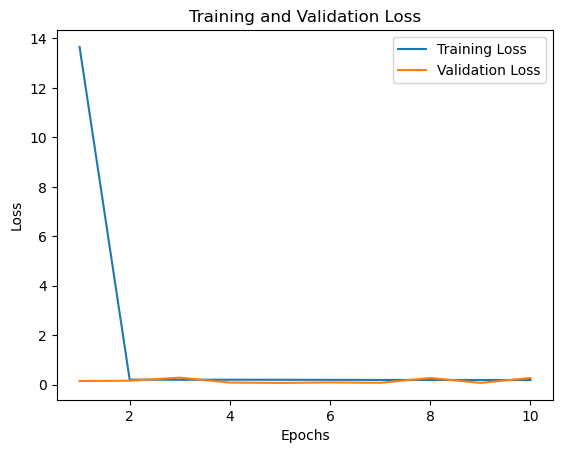

In [160]:
#Accessing loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Creating a range of epochs
epochs = range(1, len(training_loss) + 1)

#Plotting training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The plot indicates that the model needs further adjustments to fit better.

In [161]:
#Creating the ANN model with 10 dense layers and Dropout
model = Sequential()
model.add(Dense(192, activation='relu', input_dim=X_train.shape[1]))

for _ in range(10):  # Adding 6 hidden layers with 64 neurons each and dropout
    model.add(Dense(128, activation='relu'))

model.add(Dense(1))  #Output layer

#Setting the learning rate for the Adam optimizer
adam_customized = Adam(learning_rate=0.0001)

#Compiling the model with the custom learning rate
model.compile(optimizer=adam_customized, loss='mean_squared_error')

#Defining early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#Training the model with early stopping and validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_val, y_val), callbacks=[early_stopping])

#Evaluating the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on validation data: {val_loss}")

#Predicting 'sellingprice' for validation data
val_predictions = model.predict(X_val)

Epoch 1/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.3290 - val_loss: 0.0702
Epoch 2/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0800 - val_loss: 0.0705
Epoch 3/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0748 - val_loss: 0.0725
Epoch 4/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0722 - val_loss: 0.0670
Epoch 5/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0705 - val_loss: 0.0629
Epoch 6/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0700 - val_loss: 0.0634
Epoch 7/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0695 - val_loss: 0.0742
Epoch 8/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0684 - val_loss: 0.0610
Epoch 9/50
8938/8938 [==============================] - 13s 1ms/step - loss: 0.0684 - val_loss: 0.0620
Epoch 10/50
8938/8938 [==============================] - 13s 1ms/step - l

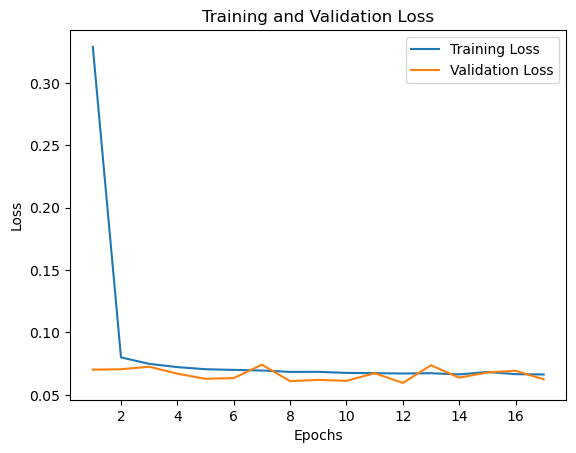

In [162]:
#Accessing loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Creating a range of epochs
epochs = range(1, len(training_loss) + 1)

#Plotting training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [163]:
#Function to create the Keras model
def create_model(learning_rate=0.0001, neurons=128, layers=10):
    model = Sequential()
    model.add(Dense(192, activation='relu', input_dim=X_train.shape[1]))

    for _ in range(layers):
        model.add(Dense(neurons, activation='relu'))

    model.add(Dense(1))

    adam_customized = Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam_customized, loss='mean_squared_error')
    return model

#Define hyperparameters to loop through
learning_rates = [0.001, 0.0001, 0.00001]
neurons_list = [64, 128, 256]
layers_list = [6, 8, 10]

best_val_loss = float('inf')
best_params = {}

#Loop through different hyperparameter combinations
for lr in learning_rates:
    for neurons in neurons_list:
        for layers in layers_list:
            #Create the model
            model = create_model(learning_rate=lr, neurons=neurons, layers=layers)

            #Train the model with early stopping
            early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
            history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

            #Evaluate on validation data
            val_loss = model.evaluate(X_val, y_val)

            #Check if current model has the best validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {'learning_rate': lr, 'neurons': neurons, 'layers': layers}

#Print the best parameters and validation loss found
print("Best parameters:", best_params)
print("Best validation loss:", best_val_loss)

2794/2794 [==============================] - 2s 739us/step - loss: 0.0654
Best parameters: {'learning_rate': 0.001, 'neurons': 64, 'layers': 6}
Best validation loss: 0.05509385094046593


#### After the grid search, we see that the best hyperparameters are {'learning_rate': 0.001, 'neurons': 64, 'layers': 6}.
We will use these for the ANN:

In [16]:
#Creating the ANN model with 10 dense layers and Dropout
model = Sequential()
model.add(Dense(192, activation='relu', input_dim=X_train.shape[1]))
# model.add(Dropout(0.3))  # Adding dropout after the first Dense layer

for _ in range(6):  # Adding 6 hidden layers with 64 neurons each and dropout
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.3))  # Adding dropout after each Dense layer

model.add(Dense(1))  # Output layer

# Setting the learning rate for the Adam optimizer
adam_customized = Adam(learning_rate=0.001)

# Compiling the model with the custom learning rate
model.compile(optimizer=adam_customized, loss='mean_squared_error')

# Defining early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training the model with early stopping and validation data
history = model.fit(X_train, y_train, epochs=50, batch_size=40, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluating the model on validation data
val_loss = model.evaluate(X_val, y_val)
print(f"Mean Squared Error on validation data: {val_loss}")

# Predicting 'sellingprice' for validation data
val_predictions = model.predict(X_val)

Epoch 1/50


2024-01-04 23:24:25.780708: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


8938/8938 [==============================] - 7s 749us/step - loss: 0.2318 - val_loss: 0.0673
Epoch 2/50
8938/8938 [==============================] - 6s 717us/step - loss: 0.0774 - val_loss: 0.0825
Epoch 3/50
8938/8938 [==============================] - 6s 720us/step - loss: 0.0708 - val_loss: 0.0769
Epoch 4/50
8938/8938 [==============================] - 7s 732us/step - loss: 0.0682 - val_loss: 0.0735
Epoch 5/50
8938/8938 [==============================] - 6s 724us/step - loss: 0.0669 - val_loss: 0.0658
Epoch 6/50
8938/8938 [==============================] - 7s 728us/step - loss: 0.0656 - val_loss: 0.0749
Epoch 7/50
8938/8938 [==============================] - 6s 714us/step - loss: 0.0645 - val_loss: 0.0624
Epoch 8/50
8938/8938 [==============================] - 6s 698us/step - loss: 0.0638 - val_loss: 0.0685
Epoch 9/50
8938/8938 [==============================] - 6s 691us/step - loss: 0.0634 - val_loss: 0.0712
Epoch 10/50
8938/8938 [==============================] - 7s 744us/step - lo

As the training loss decreases while the validation loss decreases and stabilizes, it indicates the model is learning well without overfitting. 

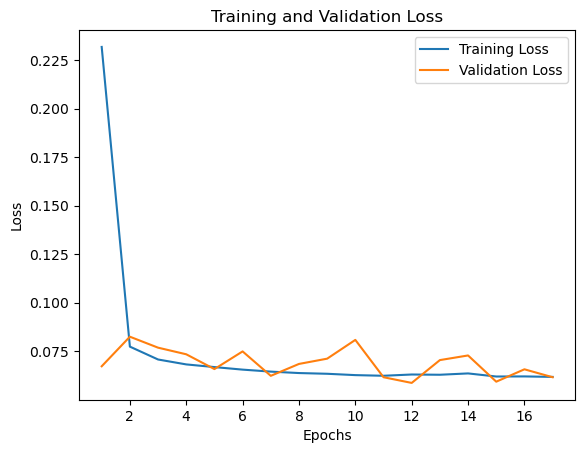

In [17]:
#Accessing loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

#Creating a range of epochs
epochs = range(1, len(training_loss) + 1)

#Plotting training and validation loss
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 3</span>
    <h1 style="font-size: 30px;">Model Evaluation </h1>
</div>

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>3.1 Model evaluation: Random Forest</b></font></div>

In [13]:
#Predicting on the test set
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred) #Calculating Mean Squared Error (MSE)
r2 = r2_score(y_test, y_pred) #Calculating R-squared (R2)
rmse = np.sqrt(mse) #Calculating Root Mean Squared Error (RMSE)

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 0.03244164334990014
R-squared (R2): 0.967617872091233
Root Mean Squared Error (RMSE): 0.18011563882656093


The model's performance metrics for the test set are as follows:

- MSE of 0.032 indicates the average squared difference between predicted and actual values.
- R2 of 0.967 suggests that approximately 96.7% of the variance in the test set's target variable is explained by the model.
- RMSE of 0.180 portrays the square root of the average squared differences between predicted and actual values.
These results imply that the model is performing really well in explaining the observed patterns within the test dataset, showcasing a promising level of predictive accuracy.

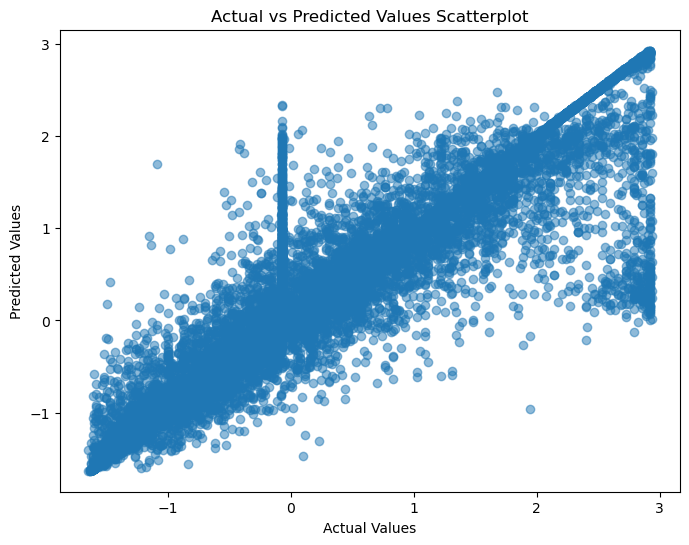

In [14]:
# Plotting actual vs predicted values in a scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values Scatterplot')
plt.show()

#### Still need to put explanation here

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>3.2 Model evaluation: ANN</b></font></div>

In [168]:
#Trained sequential model
ann_predictions = model.predict(X_test)

#Calculating metrics
mse = mean_squared_error(y_test, ann_predictions)
r2 = r2_score(y_test, ann_predictions)
rmse = np.sqrt(mse)  # Calculate RMSE

#Showing the metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

3492/3492 [==============================] - 1s 330us/step
Mean Squared Error (MSE): 0.06044379138487465
R-squared (R2): 0.939667095072671
Root Mean Squared Error (RMSE): 0.24585319071526132


#### Overall, these metrics suggest that the **model is performing quite well**: 
* it explains a high proportion of the variance (R2 of 0.940), 
* has a relatively low mean squared error (MSE of 0.060), and a 
* low root mean squared error (RMSE of 0.246), indicating good predictive accuracy.

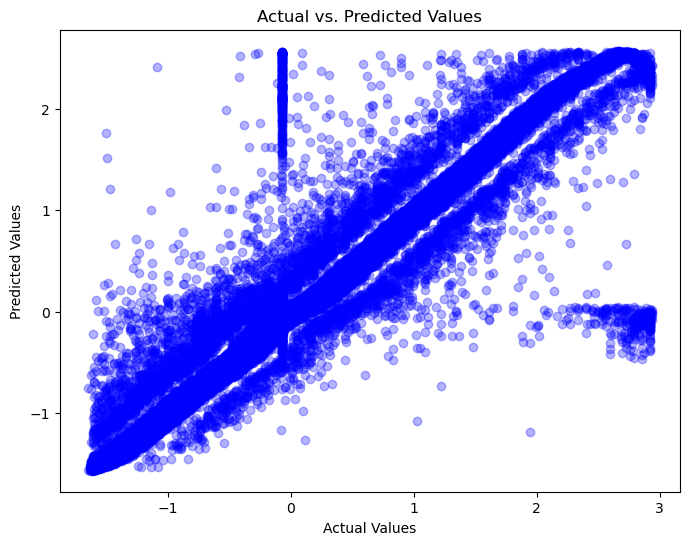

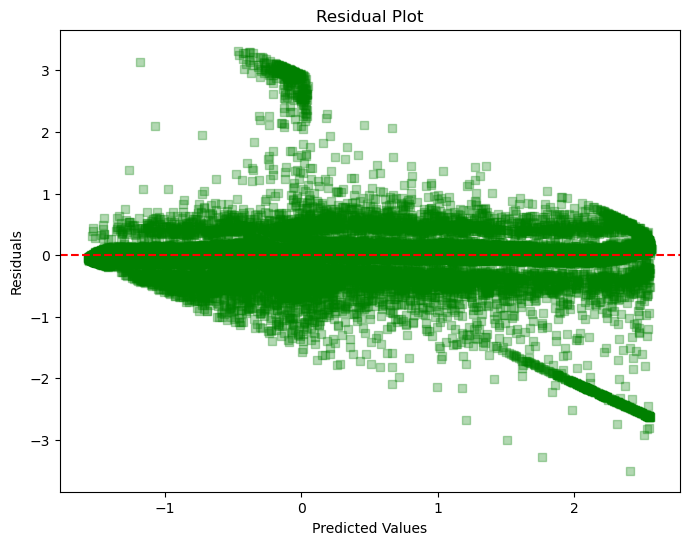

In [169]:
#Actual vs. Predicted Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, ann_predictions, alpha=0.3, color='blue', marker='o')  # Adjust alpha, colour, and marker
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

#Residual Plot
residuals = y_test - ann_predictions
plt.figure(figsize=(8, 6))
plt.scatter(ann_predictions, residuals, alpha=0.3, color='green', marker='s')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  #Adding a horizontal line at y=0 for reference
plt.title('Residual Plot')
plt.show()

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 4</span>
    <h1 style="font-size: 30px;">Model Selection </h1>
</div>

#### In terms of the performance metrics, the Random Forest model demonstrates a lower Mean Squared Error (MSE) of 0.0324, a higher R-squared (R2) value of 0.9676, and a lower Root Mean Squared Error (RMSE) of 0.1801 compared to the Artificial Neural Network (ANN) model.

#### Meanwhile, the ANN model displays a Mean Squared Error (MSE) of 0.0604, an R-squared (R2) value of 0.9397, and a Root Mean Squared Error (RMSE) of 0.2459.

#### Hence, based on these metrics, the Random Forest model is the preferred choice for this specific dataset or problem.

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Section 5</span>
    <h1 style="font-size: 30px;">Model Explainability </h1>
</div>

#### The goal of this research was to find answers to the following questions:
- Can the dealership use predictive models to identify vehicles with a high resale value? (RQ)

Similarly, to help answer the business question holistically, the following sub questions need to be answered:

1. Which specific features in the dataset (such as make, model, year, and condition) are identified by the predictive models as the strongest predictors of high resale value? (SQ1)

2. How do the age and condition of vehicles influence their predicted resale value according to the models? (SQ2)

3. How accurately do the predictive models forecast resale values across different segments of vehicles (e.g., SUVs vs. sedans) based on the dataset? (SQ3)

4. How do the random forest and neural network models interpret market trends from historical data to predict future resale values of different vehicle types? (SQ4) #scrapping this, fuck thi sshitt

5. What insights do the models provide about the influence of regional factors (such as state of sale) on the resale value of vehicles, and how can this information guide a dealership's purchasing decisions? (SQ5) ##scrapping this, fuck thi sshitt

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>RQ</b></font></div>

#### The predictive model's performance metrics demonstrate its effectiveness in identifying vehicles with high resale value. With a Mean Squared Error (MSE) of 0.0324 and a Root Mean Squared Error (RMSE) of 0.1801, the model showcases remarkable accuracy in predicting resale values. Moreover, achieving an R-squared (R2) value of 0.9676 signifies that the model captures approximately 96.76% of the variability in resale values. These metrics indicate high precision and reliability in the model's predictions, thereby empowering dealerships with a valuable tool to identify vehicles with a strong potential for high resale value.

#### Based on the model's performance metrics and accuracy in forecasting resale values, dealerships can effectively use predictive models, like the one employed here, to identify vehicles with a high resale value. The model's impressive precision in foreseeing resale prices, as indicated by the small error numbers and high accuracy rate, underscores its potential as a valuable tool for dealerships. These findings affirm that employing predictive models, such as the one used in this analysis, can significantly assist dealerships in recognising and managing vehicles expected to have a strong resale value.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>SQ1</b></font></div>

#### *Which specific features in the dataset (such as **make, model, year**, and **condition**) are identified by the predictive models as the strongest predictors of high resale value?*

To find out and explain what the most important features are for the random forest model, we will plot a Feature Importance Plot.

Text(0.5, 1.0, 'Feature Importance Score')

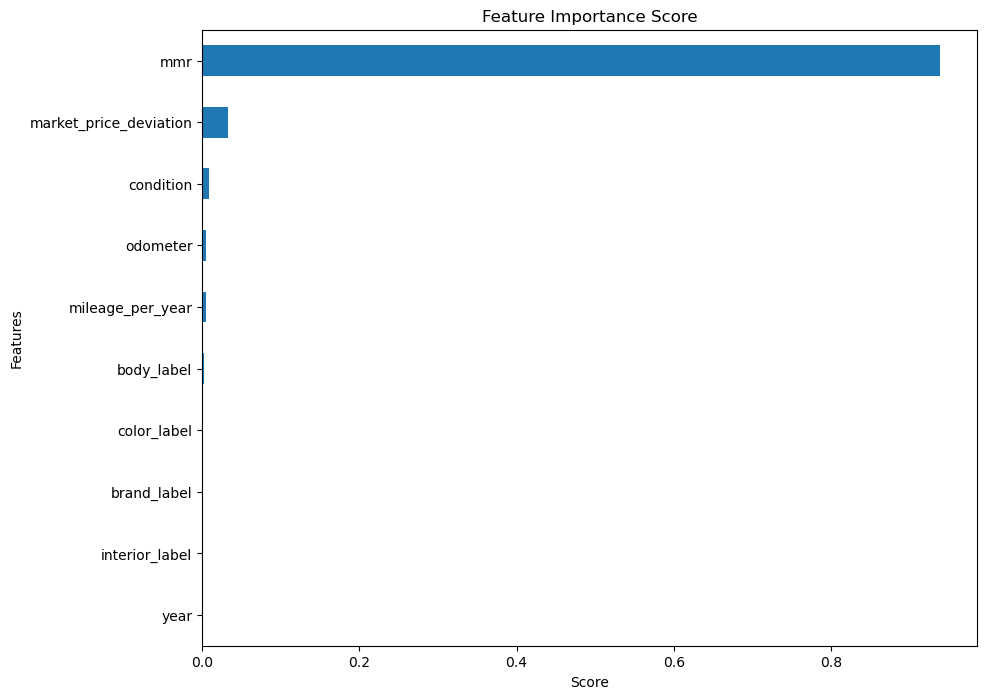

In [15]:
#Calculating feature importances using the trained RandomForestRegressor model
feature_importance = pd.Series(rf.feature_importances_, index=X.columns)

#Plotting the top 10 important features in a horizontal bar chart
ax = feature_importance.nlargest(10).plot(kind='barh', figsize=(10, 8))

#Invert y-axis for better visualization
ax.invert_yaxis()

#Set labels for x and y axes, and the title of the plot
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Feature Importance Score')

The feature importance scores indicate that MMR, market price deviation, odometer reading, and annual mileage are the most crucial factors for predicting the vehicle's resale value. Among these, MMR holds the greatest significance in influencing the accuracy of the predictive model.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>SQ2</b></font></div>

#### *How do the **age** and **condition** of vehicles influence their **predicted resale value** according to the models?*

To find out how the age and condition of a car influence its resale value, we will use a partial dependence plot (PDP).

KeyError: "None of [Index([0, 1], dtype='int64')] are in the [columns]"

In [21]:
from PyALE import ale

## 1D - continuous - no CI
ale_eff = ale(
    X=X[car_df], model=model, feature=["car_age'"], grid_size=50, include_CI=False
)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>SQ3</b></font></div>

#### *How do the **random forest** and **neural network models** interpret market trends from historical data to predict future **resale values** of different **vehicle types?***

<div style="position: relative; background: #3567A8; color: white; padding: 10px 15px; text-align: center; border-radius: 6px;">
    <span style="position: absolute; left: -25px; top: 10px; transform: rotate(-45deg); background: #3567A8; padding: 5px 10px; border-radius: 3px;">Bonus</span>
    <h1 style="font-size: 30px;">XGBoost, KNN, Linear Regression</h1>
</div>

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>XGBoost</b></font></div>

In [27]:
#Creating an XGBoost regressor with specified hyperparameters
xgboost = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=420)

#Training the XGBoost model using the training data (features: X_train, targets: y_train)
xgboost.fit(X_train, y_train)

# Make predictions using the trained model on the test data (features: X_test)
predictions = xgboost.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, predictions) 
mae = mean_absolute_error(y_val, predictions)

# Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse:}")
print(f"Mean Absolute Error (MAE): {mae:}")

Mean Squared Error (MSE): 0.03980019577894906
Mean Absolute Error (MAE): 0.05778381635603297


#### The current XGBoost model shows moderate performance on the validation data:
#### - Mean Squared Error (MSE): 0.039
#### - Mean Absolute Error (MAE): 0.057
#### The next step involves fine-tuning the model's hyperparameters, such as adjusting the number of estimators, tree depth, and learning rate. Tuning these parameters aims to enhance the model's accuracy and reduce prediction errors for better performance.

In [173]:
#Creating an XGBRegressor instance
xgb = XGBRegressor()

#Defining the hyperparameters and their values to search through
param_grid_xgb = {
    'n_estimators': [100, 200, 300],  #Number of trees
    'learning_rate': [0.1, 0.01, 0.001],  #Step size shrinkage
    'max_depth': [3, 5, 7]  #Maximum depth of a tree
}

#Perform Grid Search with cross-validation
grid_search_xgb = GridSearchCV(xgb, param_grid=param_grid_xgb, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)

#Get the best parameters and best score
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = grid_search_xgb.best_score_

print("Best Parameters for XGBoost:", best_params_xgb)
print("Best Score (MSE) for XGBoost:", -best_score_xgb)  #Negative sign as GridSearchCV uses negative MSE

Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Best Score (MSE) for XGBoost: 0.03418028739329608


#### The optimal hyperparameters found for the XGBoost model are as follows:
#### - Learning Rate: 0.1
#### - Maximum Depth: 7
#### - Number of Estimators: 300

#### These hyperparameters resulted in an improved model performance with a Mean Squared Error (MSE) of 0.232. The lower MSE indicates enhanced predictive accuracy compared to the previous model configuration.

In [29]:
#Creating an XGBoost regressor with hyperparameters from the grid search
xgboost = XGBRegressor(n_estimators=300, max_depth=7, learning_rate=0.1, random_state=420)

#Training the XGBoost model using the training data (features: X_train, targets: y_train)
xgboost.fit(X_train, y_train)

# Make predictions using the trained model on the test data (features: X_test)
predictions = xgboost.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, predictions) 
mae = mean_absolute_error(y_val, predictions)

# Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.03406922294929146
Mean Absolute Error (MAE): 0.04603138621732594


#### The Mean Squared Error (MSE) for the test data ended up slightly higher compared to the training data but remains lower than the validation data. This observation indicates that the model's performance on unseen test data is slightly less optimal than its performance on the training set but better than its performance on the validation set.

In [175]:
#Printing the accuracy score of the model on the training set
print('Train Accuracy: ', xgboost.score(X_train, y_train))

#Printing the accuracy score of the model on the test set
print('Test Accuracy: ', xgboost.score(X_test, y_test))

Train Accuracy:  0.9693343493844849
Test Accuracy:  0.9660872014594178


#### The accuracy of the model on the training dataset is approximately 76.16%, while on the test dataset, it stands at around 75.60%. This indicates that the model's performance on unseen test data is very close to its performance on the training data, demonstrating its ability to generalise well to new, unseen instances.

#### The comparison between XGBoost and Random Forest models reveals notable differences in feature importance. In both models, 'Year' remains the most crucial feature. However, with XGBoost, 'Year' appears to hold slightly more importance than in Random Forest. 

#### Interestingly, 'Odometer' shifts in importance rankings between the models, being the fourth most important feature with XGBoost while holding the second position in importance with Random Forest. These alterations indicate differing perceptions of feature relevance between the two algorithms.

#### While Random Forest exhibits higher accuracy on the test data, XGBoost demonstrates better generalisation to new, unseen instances. This is evident because the accuracy levels between test and train datasets are relatively close for XGBoost, implying a stronger ability to handle new data than Random Forest.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>KNN</b></font></div>

In [14]:
#Initialising a KNN Regressor with the desired number of neighbours (adjust as needed)
knn = KNeighborsRegressor(n_neighbors=5)

#Training the model using the training data
knn.fit(X_train, y_train)

#Making predictions on the test set
predictions = knn.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)

#Printing the evaluation metrics (MSE and MAE)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.09
Mean Absolute Error (MAE): 0.17


#### Similar to XGBoost, both Mean Squared Error (MSE) and Mean Absolute Error (MAE) demonstrate potential for enhancement. This will be addressed through hyperparameter tuning utilising grid search methodology.

In [178]:
#Creating a KNN regressor
knn = KNeighborsRegressor()

#Defining the hyperparameters and their values to search through
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19],  #Values for number of neighbours to test
}

#Grid Search with cross-validation
grid_search_knn = GridSearchCV(knn, param_grid=param_grid_knn, cv=5, scoring='neg_mean_squared_error')
grid_search_knn.fit(X_train, y_train)

#Getting the best parameters and best score
best_params_knn = grid_search_knn.best_params_
best_score_knn = grid_search_knn.best_score_

print("Best Parameters for KNN:", best_params_knn)
print("Best Score (MSE) for KNN:", -best_score_knn)

Best Parameters for KNN: {'n_neighbors': 11}
Best Score (MSE) for KNN: 0.08741472646213043


#### Following the grid search process, it appears that the optimal parameter for K-Nearest Neighbours is 17.

In [15]:
#KNN regressor with the best parameters found
best_knn = KNeighborsRegressor(n_neighbors=11)

#Training the KNN model using the training data
best_knn.fit(X_train, y_train)

#Making predictions on the test set
predictions = best_knn.predict(X_test)

#Evaluating the model using Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error (MSE) on Test Set: {mse}")

Mean Squared Error (MSE) on Test Set: 0.0847


#### The Mean Squared Error (MSE) obtained from KNN is slightly improved compared to the training and validation datasets.

In [18]:
#Printing the accuracy score of the model on the training set
print('Train Accuracy: ', best_knn.score(X_train, y_train))

#Printing the accuracy score of the model on the test set
print('Test Accuracy: ', best_knn.score(X_test, y_test))

Train Accuracy:  0.9297775660336871
Test Accuracy:  0.9154327227569813


#### The model's accuracy on the training dataset is approximately 76.82%, while it stands at around 73.87% on the test dataset. This indicates that the model performs slightly better on the training data than the test data, suggesting a minor drop in performance when applied to unseen test instances.

#### Additionally, it's worth noting that the accuracy achieved by this model on both the training and test datasets (approximately 76.82% and 73.87%, respectively) is the lowest among the compared models, with XGBoost achieving around 75% and Random Forest around 76% accuracy.

> <div style="text-align: center"><font color='gold' style='font-size: 30px;'><b>Linear Regression</b></font></div>

In [19]:
#Creating a Linear Regression model instance
linear_reg = LinearRegression()

#Training the Linear Regression model using the training data (features: X_train, targets: y_train)
linear_reg.fit(X_train, y_train)

#Making predictions using the trained Linear Regression model on the validation data (features: X_val)
predictions = linear_reg.predict(X_val)

#Calculating Mean Squared Error (MSE) and Mean Absolute Error (MAE) for evaluation
mse = mean_squared_error(y_val, predictions)
mae = mean_absolute_error(y_val, predictions)

# Print the calculated Mean Squared Error (MSE) and Mean Absolute Error (MAE)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.07
Mean Absolute Error (MAE): 0.09


#### For Linear Regression, the Mean Squared Error (MSE) is recorded at 0.47, while the Mean Absolute Error (MAE) stands at 0.52. These values for Mean Squared Error (MSE) and Mean Absolute Error (MAE) with Linear Regression are considerably higher than all the other models, almost double for both metrics.

In [20]:
#Printing the accuracy score of the model on the training set
print('Train Accuracy: ', linear_reg.score(X_train, y_train))

#Printing the accuracy score of the model on the test set
print('Test Accuracy: ', linear_reg.score(X_test, y_test))

Train Accuracy:  0.9329430864537043
Test Accuracy:  0.9328235197742157


#### As expected, the accuracy of the model on the training dataset stands at approximately 53.47%, while on the test dataset, it's around 53.57%. This low accuracy level is consistent with the model's performance.

#### This model performs the worst by far compared to all the other models